In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as transforms
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
    # local path
#    vector_path = "../data.nosync/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

### Loading the data

In [6]:
# Setting up a Dataset object for DataLoader
class BuildingVectorDataset(Dataset):
    def __init__(self, path, operators, node_to_predict, transform=None):
        '''Stores the directory and filenames of the individual .pt files.'''
        super().__init__(path, transform)
        # store directory of individual files
        self.path = path
        # get filenames of individual .pt files
        self.filenames = [file for file in os.listdir(path) if file.endswith(".pt")]
        # storing the node for which the prediction should be conducted
        self.node_to_predict = node_to_predict

        # store indices of the operators within operator_order for slicing in the .get() method
        self.operators = sorted([operator_order.index(operator) for operator in operators if operator in operator_order])

        # store transformation
        self.transform = transform

    def len(self):
        '''Enables dataset length calculation.'''
        return len(self.filenames)

    def get(self, index):
        '''Enables indexing, returns HeteroData object which contains nodes, edges and labels.'''
        # get filename associated with given index
        filename = self.filenames[index]

        # load the file with the filename
        sample = torch.load(os.path.join(self.path, filename))

        # only return the operators specified in the init method by slicing sample.y
        sample[self.node_to_predict].y = sample[self.node_to_predict].y[:,self.operators]

        # apply given transformation if specified
        #if self.transform:
        #    graph = self.transform(graph)

        return sample

### Model design

In [7]:
# Define the model
class HeteroGNN(nn.Module):
    def __init__(self, node_features, node_to_predict, metadata, n_classes):
        super().__init__()
        self.conv1 = pyg_nn.HGTConv(in_channels=node_features,
                             out_channels=64, metadata=(metadata))
        self.conv2 = pyg_nn.HGTConv(in_channels=64, out_channels=n_classes, metadata=(metadata))

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: torch.relu(x) for k, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict[node_to_predict]  # Only return the building predictions

    def get_n_parameters(self):
        n_parameters = sum(p.numel() for p in self.parameters())
        return n_parameters

    def __str__(self):
        return f"Heterogeneous GNN with {self.get_n_parameters():,} parameters"

## Elimination model

In [8]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data")
path_to_validation_data = os.path.join(vector_path, "training_data")

# determine the name of the node that should be predicted
node_to_predict = "building"

# composing various random transforms that should be applied to the data
#transform = transforms.Compose([transforms.ToUndirected()])

# operators that the model should be optimized towards
operators = ["elimination"]

# batch size for DataLoaders
batch_size = 10

# construct training DataLoader
training_set = BuildingVectorDataset(path_to_training_data, operators=operators, node_to_predict=node_to_predict, transform=None)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, operators=operators, node_to_predict=node_to_predict, transform=None)
validation_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(training_set):,} samples in the training set.")

1,000 samples in the training set.
1,000 samples in the training set.


In [9]:
# extracting the relevant metadata from the data to set up the model
n_building_features = training_set.get(0)["building"]["x"].shape[1]
n_road_features = training_set.get(0)["road"]["x"].shape[1]
node_features = {"building": n_building_features, "road": n_road_features}
n_classes = training_set.get(0)["building"]["y"].shape[1]

print(f"{n_building_features} building features, {n_road_features} road features, {n_classes} operators")

# construct the model
model = HeteroGNN(node_features, node_to_predict=node_to_predict, metadata=training_set.get(0).metadata(), n_classes=n_classes)
model.to(device)

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

0 building features, 0 road features, 1 operators


### Training loop

In [10]:
# number of epochs
n_epochs = 10

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, graph in enumerate(training_loader):
        n_training_batches += 1
        # target operators
        operators = graph.y_dict[node_to_predict]
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for graph in validation_loader:
            n_validation_batches += 1
            # target operators
            operators = graph.y_dict[node_to_predict]
            
            # moving the features to device
            graph = graph.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="eli", n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 10/100
epoch 1/10, step 20/100
epoch 1/10, step 30/100
epoch 1/10, step 40/100
epoch 1/10, step 50/100
epoch 1/10, step 60/100
epoch 1/10, step 70/100
epoch 1/10, step 80/100
epoch 1/10, step 90/100
epoch 1/10, step 100/100
epoch 1 finished, training loss: 0.744, validation loss: 0.697
epoch 2/10, step 10/100
epoch 2/10, step 20/100
epoch 2/10, step 30/100
epoch 2/10, step 40/100
epoch 2/10, step 50/100
epoch 2/10, step 60/100
epoch 2/10, step 70/100
epoch 2/10, step 80/100
epoch 2/10, step 90/100
epoch 2/10, step 100/100
epoch 2 finished, training loss: 0.674, validation loss: 0.652
epoch 3/10, step 10/100
epoch 3/10, step 20/100
epoch 3/10, step 30/100
epoch 3/10, step 40/100
epoch 3/10, step 50/100
epoch 3/10, step 60/100
epoch 3/10, step 70/100
epoch 3/10, step 80/100
epoch 3/10, step 90/100
epoch 3/10, step 100/100
epoch 3 finished, training loss: 0.632, validation loss: 0.612
epoch 4/10, step 10/100
epoch 4/10, step 20/100
epoch 4/10, step 30/100
epoch 4/10, step

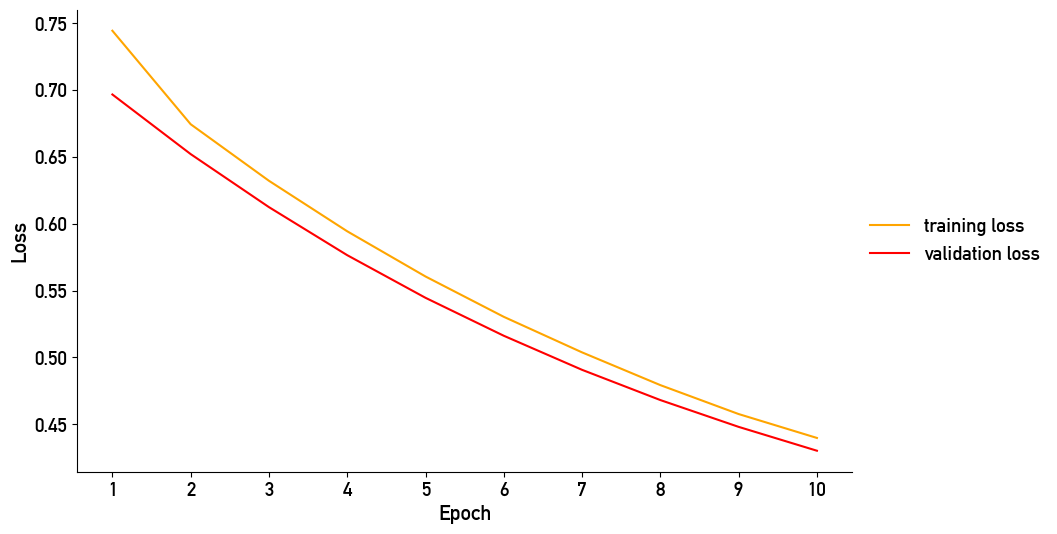

In [11]:
loss_path = os.path.join(vector_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


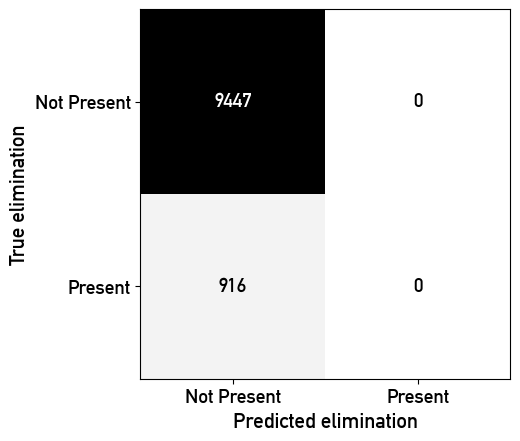

Accuracy: 0.912
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


In [12]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for graph in validation_loader:
        # target operators
        operators = graph.y_dict[node_to_predict]
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, ops="eli", n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

### Saving the model

In [13]:
# save the trained model to disk
path_to_models = os.path.join(vector_path, "models", "elimination")

model_name = get_model_name(model, ops="eli", n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

## Selection model

In [14]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data")
path_to_validation_data = os.path.join(vector_path, "training_data")

# determine the name of the node that should be predicted
node_to_predict = "building"

# composing various random transforms that should be applied to the data
#transform = transforms.Compose([transforms.ToUndirected()])

# operators that the model should be optimized towards
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]

# batch size for DataLoaders
batch_size = 10

# construct training DataLoader
training_set = BuildingVectorDataset(path_to_training_data, operators=selection_operators, node_to_predict=node_to_predict, transform=None)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, operators=selection_operators, node_to_predict=node_to_predict, transform=None)
validation_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(training_set):,} samples in the training set.")

1,000 samples in the training set.
1,000 samples in the training set.


In [15]:
# extracting the relevant metadata from the data to set up the model
n_building_features = training_set.get(0)["building"]["x"].shape[1]
n_road_features = training_set.get(0)["road"]["x"].shape[1]
node_features = {"building": n_building_features, "road": n_road_features}
n_classes = training_set.get(0)["building"]["y"].shape[1]

print(f"{n_building_features} building features, {n_road_features} road features, {n_classes} operators")

# construct the model
model = HeteroGNN(node_features, node_to_predict=node_to_predict, metadata=training_set.get(0).metadata(), n_classes=n_classes)
model.to(device)

learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

0 building features, 0 road features, 4 operators


### Training loop

In [16]:
# number of epochs
n_epochs = 10

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, graph in enumerate(training_loader):
        n_training_batches += 1
        # target operators
        operators = graph.y_dict[node_to_predict]
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for graph in validation_loader:
            n_validation_batches += 1
            # target operators
            operators = graph.y_dict[node_to_predict]
            
            # moving the features to device
            graph = graph.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="sel", n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 10/100
epoch 1/10, step 20/100
epoch 1/10, step 30/100
epoch 1/10, step 40/100
epoch 1/10, step 50/100
epoch 1/10, step 60/100
epoch 1/10, step 70/100
epoch 1/10, step 80/100
epoch 1/10, step 90/100
epoch 1/10, step 100/100
epoch 1 finished, training loss: 0.632, validation loss: 0.568
epoch 2/10, step 10/100
epoch 2/10, step 20/100
epoch 2/10, step 30/100
epoch 2/10, step 40/100
epoch 2/10, step 50/100
epoch 2/10, step 60/100
epoch 2/10, step 70/100
epoch 2/10, step 80/100
epoch 2/10, step 90/100
epoch 2/10, step 100/100
epoch 2 finished, training loss: 0.569, validation loss: 0.568
epoch 3/10, step 10/100
epoch 3/10, step 20/100
epoch 3/10, step 30/100
epoch 3/10, step 40/100
epoch 3/10, step 50/100
epoch 3/10, step 60/100
epoch 3/10, step 70/100
epoch 3/10, step 80/100
epoch 3/10, step 90/100
epoch 3/10, step 100/100
epoch 3 finished, training loss: 0.567, validation loss: 0.563
epoch 4/10, step 10/100
epoch 4/10, step 20/100
epoch 4/10, step 30/100
epoch 4/10, step

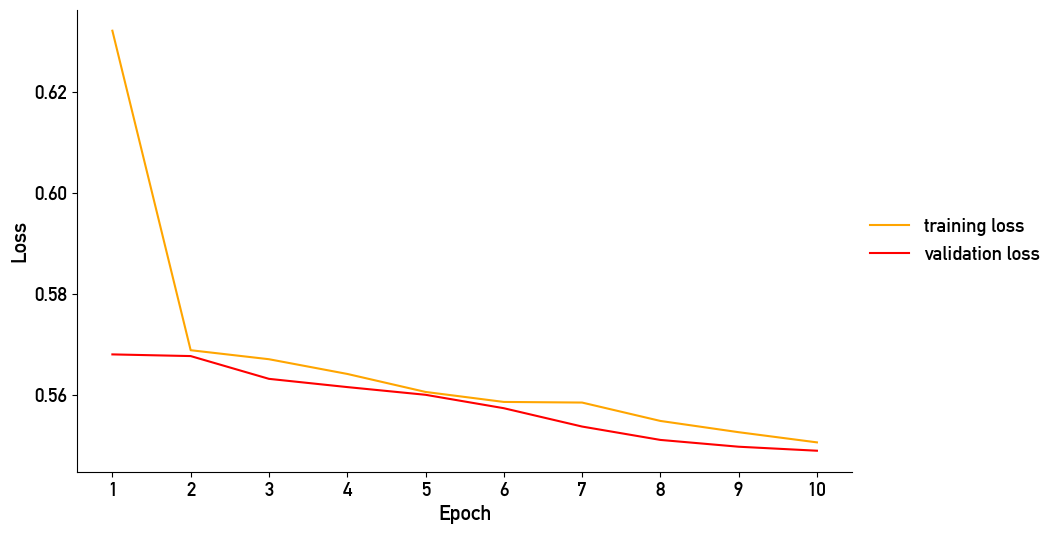

In [17]:
loss_path = os.path.join(vector_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

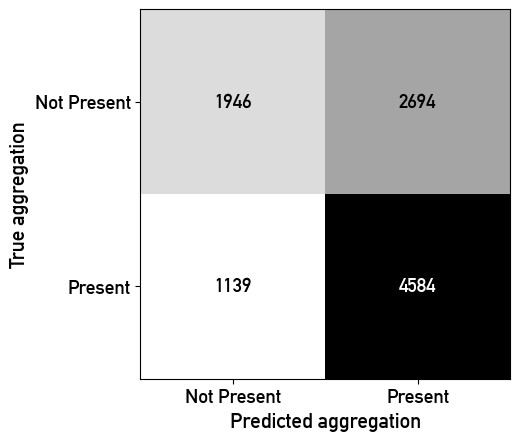

Accuracy: 0.630
Precision: 0.630
Recall: 0.801
F1 Score: 0.705


/Library/anaconda3/envs/genops/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


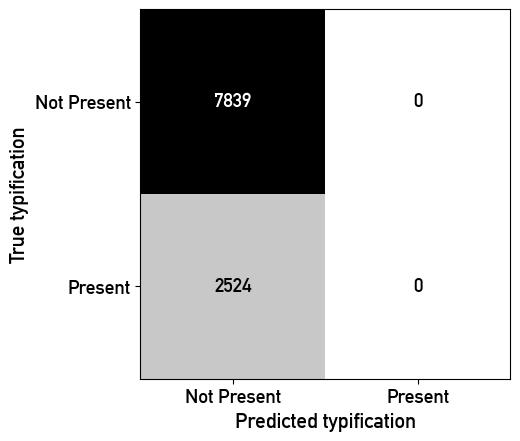

Accuracy: 0.756
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


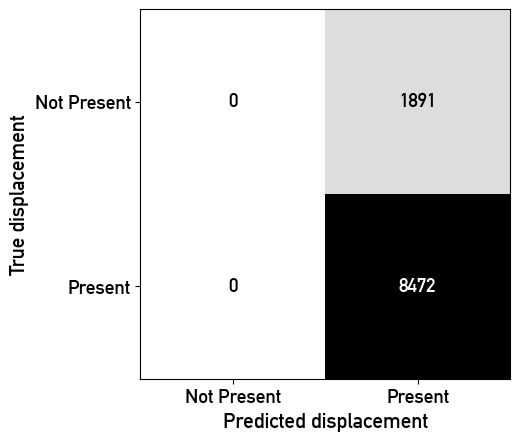

Accuracy: 0.818
Precision: 0.818
Recall: 1.000
F1 Score: 0.900


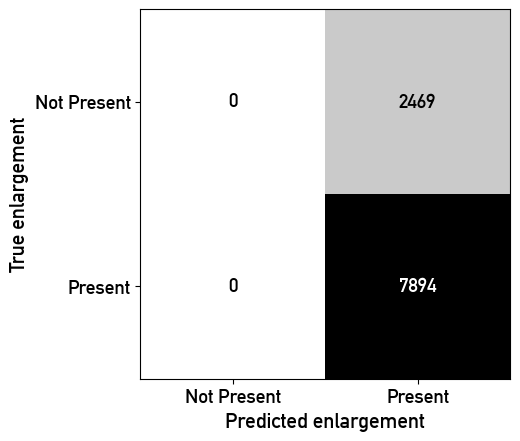

Accuracy: 0.762
Precision: 0.762
Recall: 1.000
F1 Score: 0.865


In [18]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for graph in validation_loader:
        # target operators
        operators = graph.y_dict[node_to_predict]
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, ops="sel", n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)